In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
import sklearn
from sklearn import metrics
import re

In [4]:
#Data source: https://www.kaggle.com/datasets/gauthamp10/google-playstore-apps
data_folder = os.getcwd() +"/data/"
csv_name = "Google-Playstore.csv"
data_path = data_folder + csv_name

In [5]:
df = pd.read_csv(data_path)

#Feature engineering (eng) starts
eng_df = df.drop(['Installs', 'Currency', 'Minimum Installs', 'Developer Website', 'Developer Email', 'Privacy Policy', 'App Name'], axis=1)

# pak een n sample vd dataframe
eng_df_s = eng_df.sample(n=10000, random_state=123) #small
eng_df_t = eng_df.sample(n=1000, random_state=123) #tiny
eng_df_tt = eng_df.sample(n=200, random_state=123) #teeny-tiny

#Select one for further use
eng_df = eng_df_t

In [6]:
#What kind of Size values exist, going by the text part of the string
size_cats = eng_df_s['Size'].apply(lambda x: re.findall('([\sA-Za-z]*$)', str(x))[0])
print(size_cats.value_counts())

#Knowing there are three kinds of known sizes (kb, Mb, Gb) we convert these to Mb
#But because there are also missing values or OS dependent sizes, we store this categorically in an extra column
#(known sizes will be categorized as 'known')
def process_Size(value):
    value = str(value)
    conversion = {'k':0.001, 'M':1.0, 'G':1000.0}
    if value[-1] in conversion.keys():
        value = value.replace(',', '') #added because some 
        size = float(value[:-1]) * conversion[value[-1]]
        category = 'Known'
    else:
        size = None
        category = value
    return (size, category)


temp_df = pd.DataFrame(eng_df['Size'].apply(lambda x: process_Size(x)).tolist(), columns=['Size', 'Size_category'])
eng_df['Size'] = temp_df['Size'].values
eng_df['Size_category'] = temp_df['Size_category'].values
#del temp_df ##bugged, but I'd prefer to delete

M                     9521
Varies with device     315
k                      164
Name: Size, dtype: int64


In [52]:
#Separate quantitative columns into a quantitative dataframe
q_df = eng_df[['Rating', 'Rating Count', 'Maximum Installs', 'Price', 'Size']]
standard_deviations = 3
q_df_filter = q_df.apply(lambda x: np.abs(x - x.mean()) / x.std() < standard_deviations).all(axis=1)
q_df = q_df[q_df_filter]
eng_df = eng_df[q_df_filter]

#Log-transform
#Needs to be edited so it's only applied to some columns (e.g. installs but not rating)
transf_q_df = q_df.apply(lambda x: np.log10(x, where=0<x))

In [ ]:
sns.pairplot(transf_q_df, kind="kde")
#One by one alternative: sns.distplot(col1, col2)

In [ ]:
#Only run this with sufficiently small sample
sns.pairplot(transf_q_df)

In [58]:
#PCA to see if a) quantitative variables combined show some clustering and b) wether such clusters correspond to categorical variables
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
scaler.fit(q_df)
scaled_qdf = scaler.transform(q_df)

pca = PCA(n_components=q_df.shape[1])
pca.fit(scaled_qdf)

x_pca = pca.transform(scaled_qdf)
print(scaled_qdf.shape)
print(x_pca.shape)

(938, 5)
(938, 5)


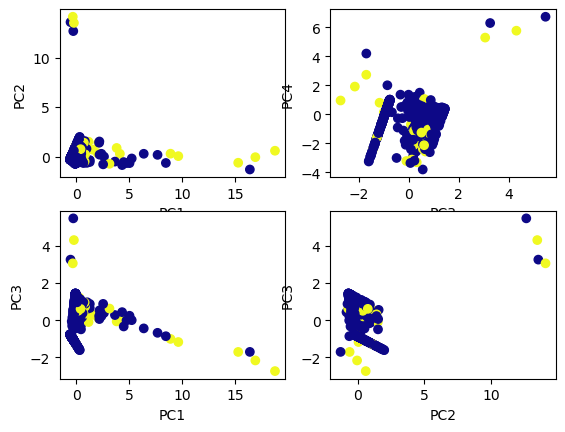

In [59]:
pcs_oi = [[1,2], [3,4], [1,3], [2,3]]
pca_fig, axs = plt.subplots(nrows = len(pcs_oi)//2, ncols=2)
for i in range(len(pcs_oi)):
    axs[i//2, i%2].scatter(x_pca[:,pcs_oi[i][0]-1],x_pca[:,pcs_oi[i][1]-1], c=eng_df['In App Purchases'], cmap='plasma')
    axs[i//2, i%2].set_xlabel('PC'+str(pcs_oi[i][0]))
    axs[i//2, i%2].set_ylabel('PC'+str(pcs_oi[i][1]))

In [63]:
pcs_explained_var = pca.explained_variance_
pcs_explained_var_perc = [i / sum(pcs_explained_var) for i in pcs_explained_var]
print(pcs_explained_var_perc)

[0.38810316703868586, 0.20290646999125508, 0.19132569543783357, 0.19082299877883696, 0.0268416687533884]


In [33]:
pd.to_datetime(df['Scraped Time']).dt.date.value_counts()

2021-06-16    1859744
2021-06-15     453200
Name: Scraped Time, dtype: int64